In [1]:
import utils_tele as utils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import imageio
import os
from scipy import interpolate

In [2]:
# physical parameters
# name of image, in quotation marks including file extension
input_image_name = r"../stars/BHs.png"
telescope_diameter_m = 6.5  # in meters
telescope_focal_length_m = 131.4  # in meters
seeing_arcsec_500nm = .015  # in arcseconds
zenith_angle_deg = 0  # in deg, zero being at the zenith
atmosphere = False  # True or False, if True simulates atmospheric perturbations. If False simulates purely diffraction effects
# arcseconds/pixel (need to calculate this based on angular size of object, number of pixels and scope plate scale) pixel size = "/pixel * 1/plate_scale
wavelength = 500e-9  # in meters
CCD_pixel_size = 2e-5  # in meters
CCD_pixel_count = 3000  # The pixel width of your simulated CCD
# simulation parameters
# number of psfs (and in turn output images) the run will generate
Num_psfs_to_gen = 10
pixels_per_ro = 30  # how well you wish to sample your phase screen

In [3]:
theta = 1.22 * wavelength / telescope_diameter_m  # in radians
T = 2.898e-3 / wavelength
r = 6e4 * (1e8 / T)**(4/3)
D = r * 2
accretion_D = D * 50
accretion_D / theta / 9.5e15

3000.359751732305

In [4]:
print(f'{r/3000:.2e} solar mass')

8.92e+06 solar mass


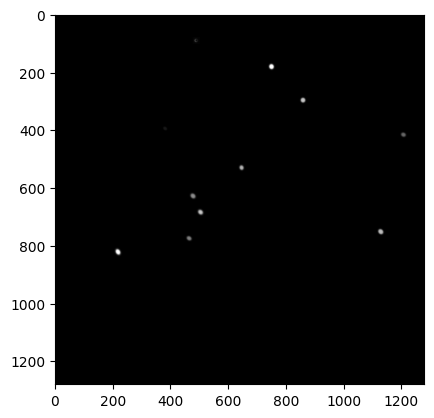

In [5]:
# open image to convolve
im = Image.open(input_image_name)
im_array = np.asarray(im)
if np.shape(im_array)[0] != np.shape(im_array)[1]:
    min_dim, max_dim = np.min((np.shape(im_array)[0], np.shape(im_array)[1])), np.max((np.shape(im_array)[0], np.shape(im_array)[1]))
    pixels_to_crop = max_dim - min_dim
    if np.shape(im_array)[0] > np.shape(im_array)[1]:
        left, right = 0, np.shape(im_array)[1]
        top, bottom = np.floor(pixels_to_crop/2), np.shape(im_array)[0] - np.ceil(pixels_to_crop/2)

    if np.shape(im_array)[0] < np.shape(im_array)[1]:
        left, right = np.floor(pixels_to_crop/2), np.shape(im_array)[1] - np.ceil(pixels_to_crop/2)
        top, bottom = 0, np.shape(im_array)[0]

    im = im.crop((left, top, right, bottom))

    im_array = np.asarray(im)

plt.imshow(im, cmap='gray')
plt.show()

In [6]:
angular_pixel_size_input_image = 206265 / telescope_focal_length_m * CCD_pixel_size * CCD_pixel_count / im_array.shape[0]

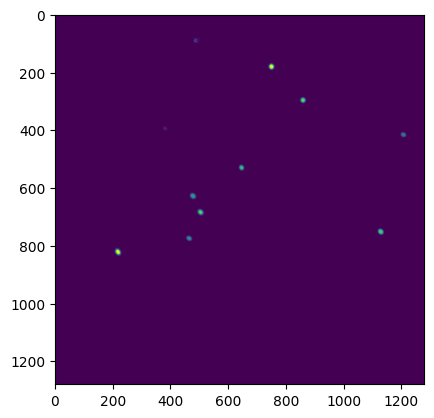

In [7]:
plt.imshow(im)
plt.show()

In [8]:
pixel_size_input_image = utils.angular_to_physical_pixels(angular_pixel_size_input_image, telescope_focal_length_m)
ideal_pixel_size_pupil = (wavelength*telescope_focal_length_m) / (len(im_array)*pixel_size_input_image)
print("pixel_size_input_image", pixel_size_input_image)

pixel_size_input_image 4.6875e-05


In [9]:
r0_cm = utils.fried_parameter_cm(wavelength, arcseconds_of_seeing_500nm=seeing_arcsec_500nm, zenith_angle_deg=zenith_angle_deg)
telescope_aperture_width_pixels = int(np.ceil((pixels_per_ro/(r0_cm*0.01))*telescope_diameter_m))
Pixel_size_pupil_plane = telescope_diameter_m/telescope_aperture_width_pixels

In [10]:
print("telescope_aperture_width_pixels: ", telescope_aperture_width_pixels)

telescope_aperture_width_pixels:  29


In [11]:
pixel_size_psf_image_plane = (wavelength*telescope_focal_length_m)/(len(im_array)*Pixel_size_pupil_plane)

In [12]:
phase_screen = np.zeros((telescope_aperture_width_pixels, telescope_aperture_width_pixels), dtype=np.complex64)
complex_amplitude = utils.quick_complex_pupil(phase_screen, array_to_propgate_size=len(im_array[0]))
intensity_image = utils.Focus_beam(complex_amplitude)

In [13]:
intensity_image.min(), intensity_image.max()

(0.0, 419904.0)

In [14]:
# plt.imshow(intensity_image)
# plt.show()

In [15]:
# plt.imshow(signal.convolve(im_array, intensity_image))


In [16]:
# x_psf_samples = np.linspace(-pixel_size_psf_image_plane*len(intensity_image)/2, pixel_size_psf_image_plane*len(intensity_image)/2, len(intensity_image))
# y_psf_samples = np.linspace(-pixel_size_psf_image_plane*len(intensity_image)/2, pixel_size_psf_image_plane*len(intensity_image)/2, len(intensity_image))

# f = interpolate.interp2d(x_psf_samples, y_psf_samples, intensity_image, kind='cubic')

# x_input_image = np.linspace(-pixel_size_input_image*len(im_array)/2, pixel_size_input_image*len(im_array)/2, len(im_array))
# y_input_image = np.linspace(-pixel_size_input_image*len(im_array)/2, pixel_size_input_image*len(im_array)/2, len(im_array))

# resampled_psf = f(x_input_image, y_input_image)
# intensity_image = resampled_psf

In [17]:
intensity_image = intensity_image - intensity_image.min()
intensity_image /= np.sum(intensity_image)

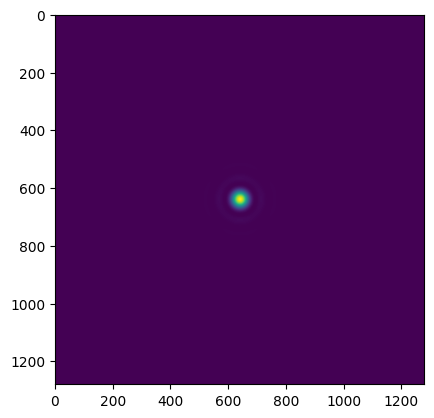

In [18]:
plt.imshow(intensity_image)
plt.show()

In [19]:
intensity_image

array([[2.23597014e-73, 7.25613797e-43, 1.81403449e-43, ...,
        7.25613797e-43, 9.07017246e-43, 1.81403449e-43],
       [6.28629938e-45, 2.33502636e-13, 9.31598744e-13, ...,
        2.08707898e-12, 9.31598744e-13, 2.33502636e-13],
       [2.50493229e-44, 9.31598744e-13, 3.71677109e-12, ...,
        8.32674940e-12, 3.71677109e-12, 9.31598744e-13],
       ...,
       [5.60029496e-44, 2.08707898e-12, 8.32674940e-12, ...,
        1.86545447e-11, 8.32674940e-12, 2.08707898e-12],
       [2.50493229e-44, 9.31598744e-13, 3.71677109e-12, ...,
        8.32674940e-12, 3.71677109e-12, 9.31598744e-13],
       [6.28629938e-45, 2.33502636e-13, 9.31598744e-13, ...,
        2.08707898e-12, 9.31598744e-13, 2.33502636e-13]])

In [20]:
convolved_array_shape = np.shape(signal.convolve(im_array, intensity_image))

In [21]:
im_array2 = im_array

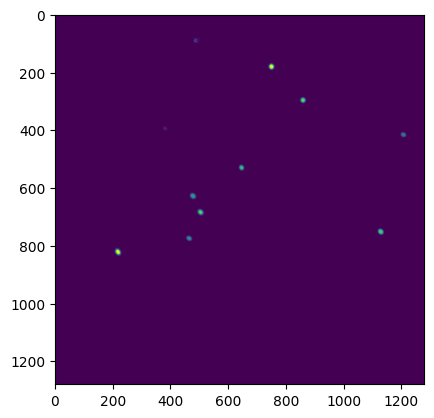

In [22]:
plt.imshow(im_array2)

In [23]:
convolved_array = np.zeros((convolved_array_shape[0], convolved_array_shape[1], 3))
# for i in range(0, 3):
convolved_array = signal.convolve(im_array2, intensity_image, method='auto')
convolved_array = np.uint8((convolved_array)*(255/np.max(convolved_array)))

In [24]:
size_conv = convolved_array.shape[0]

In [25]:
interval = (size_conv + 1) // 4

In [26]:
convolved_array = convolved_array[interval:3*interval, interval: 3*interval]

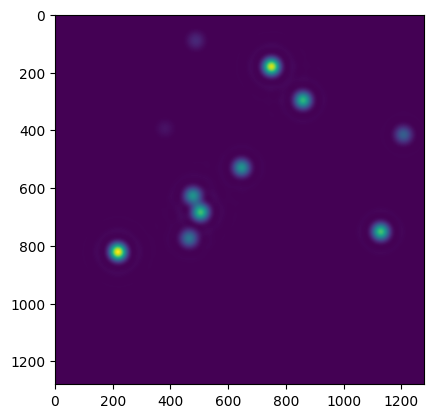

In [27]:
plt.imshow(convolved_array)
plt.show()

In [28]:
convolved_array.sum() / im_array2.sum()

9.677625892457968

In [29]:
x_psf_samples = np.linspace(-pixel_size_input_image*len(convolved_array)/2, pixel_size_input_image*len(convolved_array)/2, len(convolved_array))
y_psf_samples = np.linspace(-pixel_size_input_image*len(convolved_array)/2, pixel_size_input_image*len(convolved_array)/2, len(convolved_array))

x_CCD = np.linspace(-CCD_pixel_size*CCD_pixel_count/2,CCD_pixel_size*CCD_pixel_count/2, CCD_pixel_count)
y_CCD = np.linspace(-CCD_pixel_size*CCD_pixel_count/2,CCD_pixel_size*CCD_pixel_count/2, CCD_pixel_count)

output_image = np.zeros((CCD_pixel_count, CCD_pixel_count, 3))
f = interpolate.interp2d(x_psf_samples, y_psf_samples, convolved_array, kind='cubic')
output_image = f(x_CCD, y_CCD)
output_image = np.uint8((output_image)*(255/np.max(output_image)))

In [30]:
current_directory = os.getcwd()
final_directory = os.path.join(current_directory, r'output_images_2')
if not os.path.exists(final_directory):
    os.makedirs(final_directory)

os.chdir(final_directory)

imageio.imwrite('test.jpg', output_image)

os.chdir(current_directory)

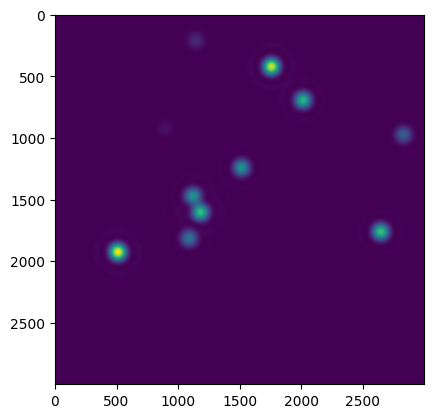

In [31]:
plt.imshow(output_image)
plt.show()